## CSC 466 - Final Report

### Team Members: Killian Brait and Nick Ambrose

<hr>

### Introduction

In this report, we'll examine a dataset of divorce data that includes the answers to 54 relationship-therapy-related questions.

In [42]:
import pandas as pd
import numpy as np

# Load the dataset
data = pd.read_csv('data/divorce_data.csv', sep=';')

# Print the first 5 rows
data.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q46,Q47,Q48,Q49,Q50,Q51,Q52,Q53,Q54,Divorce
0,2,2,4,1,0,0,0,0,0,0,...,2,1,3,3,3,2,3,2,1,1
1,4,4,4,4,4,0,0,4,4,4,...,2,2,3,4,4,4,4,2,2,1
2,2,2,2,2,1,3,2,1,1,2,...,3,2,3,1,1,1,2,2,2,1
3,3,2,3,2,3,3,3,3,3,3,...,2,2,3,3,3,3,2,2,2,1
4,2,2,1,1,1,1,0,0,0,0,...,2,1,2,3,2,2,2,1,0,1


<hr>

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

features = data.drop('Divorce', axis=1, inplace=False)
target = data['Divorce']

scaler = StandardScaler()

# Standardize the features to have mean = 0 and variance = 1
features_standardized = scaler.fit_transform(features)

### Data Analysis

Exploring the dataset to see what we should do when modeling to gain the most knowledge out of this dataset.

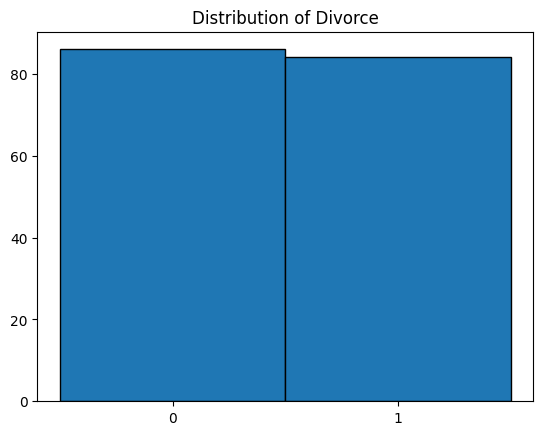

In [44]:
# Check the distribution of the target variable (Divorce)
plt.hist(data['Divorce'], bins=[-0.5, 0.5, 1.5], edgecolor='black')
plt.xticks([0,1])
plt.title('Distribution of Divorce')
plt.show()

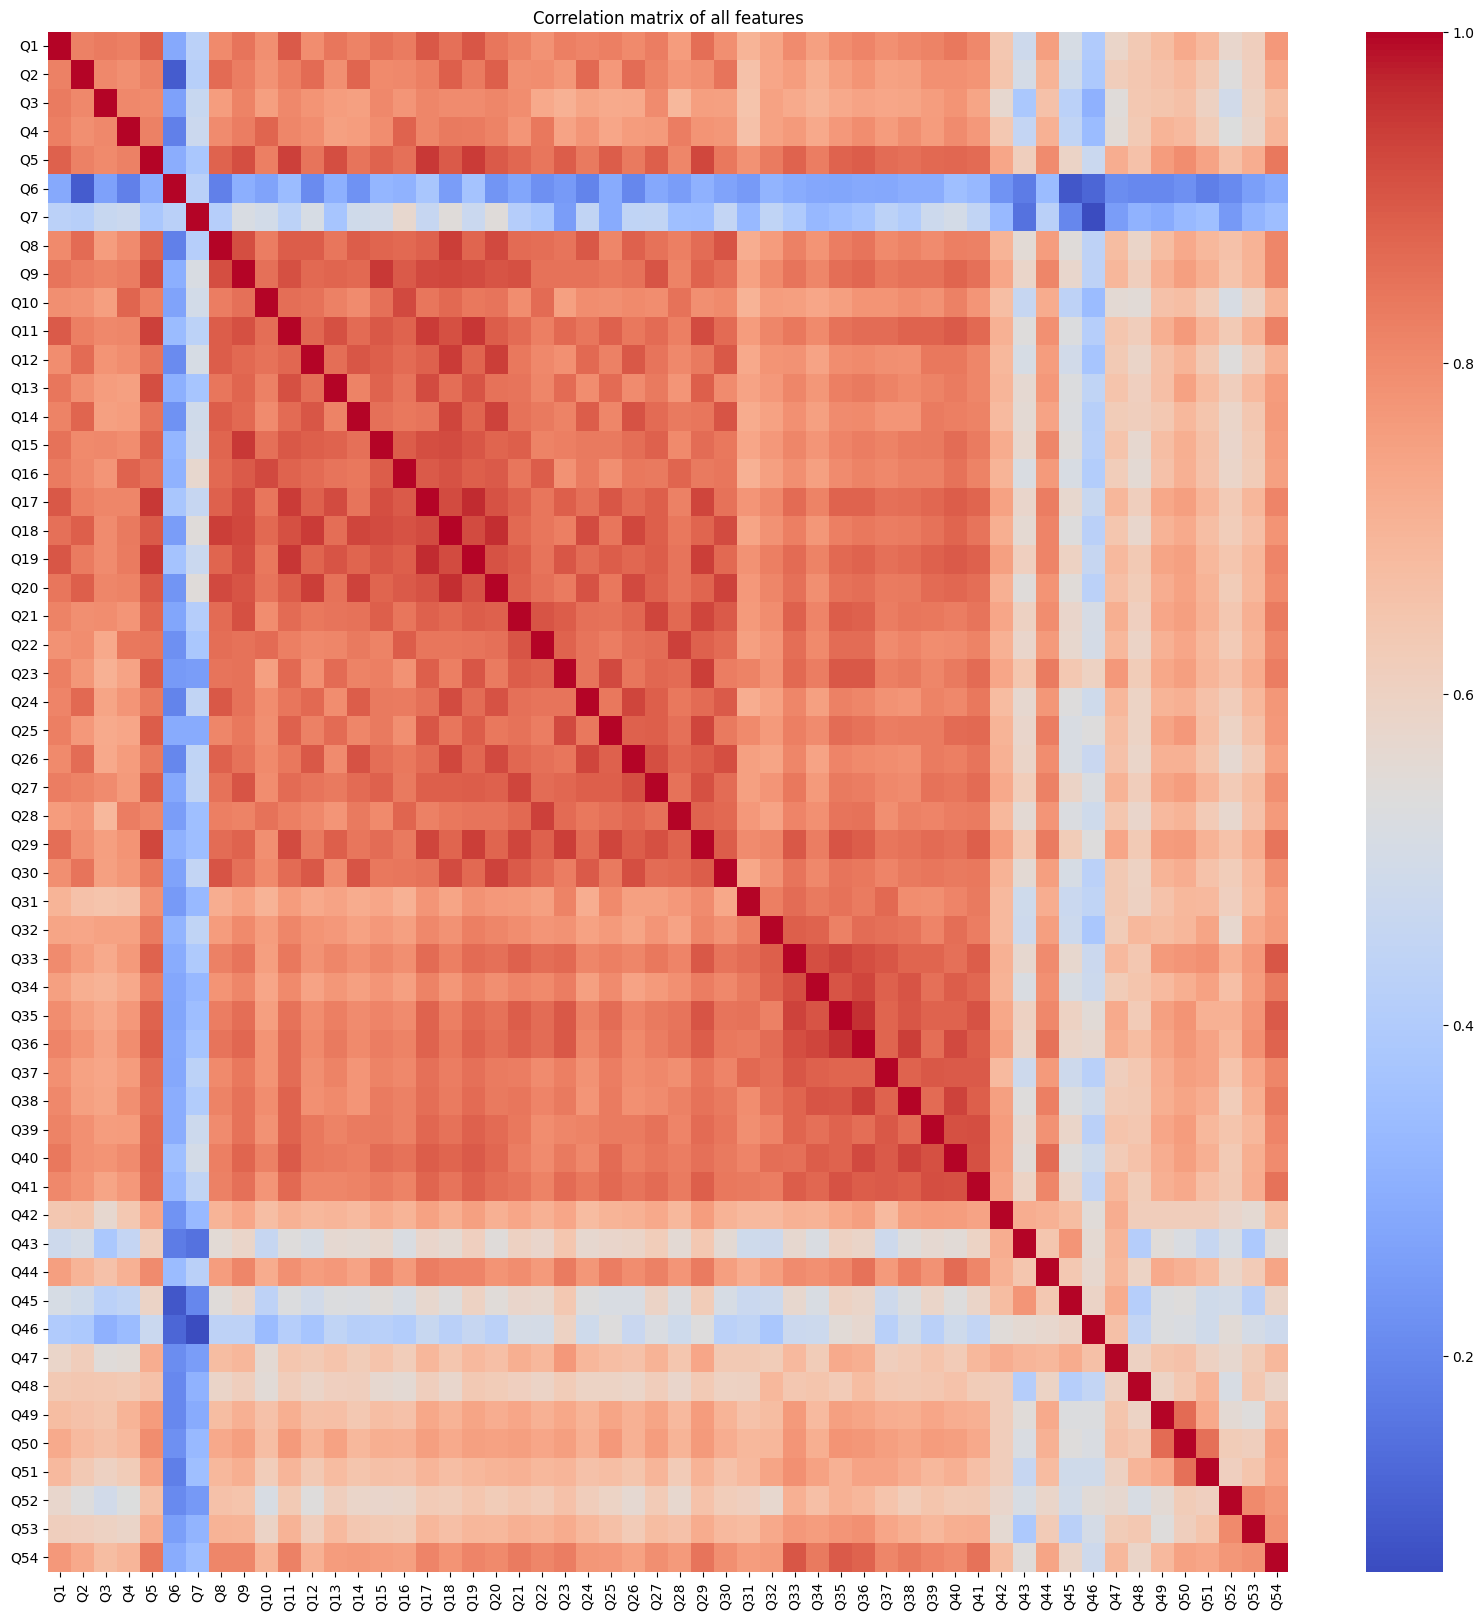

In [45]:
# Check the correlation of the features
corr_matrix = features.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title("Correlation matrix of all features")
plt.show()

This data analysis shows us two very important things.

1. The dataset is balanced, there are a similar number of positive and negative classes, which means that the model will not be biased towards one class.
2. Many features are highly correlated with each other, which means that we can reduce the number of features without losing much information. This is what we'll do next.

<hr>

In [49]:
def euclidean_distance(a, b):
    """
    Calculate the Euclidean distance between two points.
    """
    return np.sqrt(np.sum((a - b)**2, axis=1))

class Project_KMeans:
    def __init__(self, n_clusters=8, max_iter=300, random_state=None, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol  # Tolerance to decide if centroids have significantly changed
        np.random.seed(random_state)

    def init_centroids(self, X):
        """
        Initialize the centroids as k random samples of X.
        """
        random_idxs = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        self.centroids = X[random_idxs, :]

    def assign_clusters(self, X):
        """
        Assign each instance of X to the nearest centroid.
        """
        distances = np.zeros((X.shape[0], self.n_clusters))
        for i in range(self.n_clusters):
            distances[:, i] = euclidean_distance(X, self.centroids[i])
        self.labels = np.argmin(distances, axis=1)

    def update_centroids(self, X):
        """
        Update each centroid to be the mean of the instances that are assigned to it.
        """
        new_centroids = np.zeros((self.n_clusters, X.shape[1]))
        for i in range(self.n_clusters):
            new_centroids[i] = np.mean(X[self.labels == i, :], axis=0)
        return new_centroids

    def fit(self, X):
        """
        Run the K-means algorithm on the data X.
        """
        self.init_centroids(X)
        for _ in range(self.max_iter):
            self.assign_clusters(X)
            new_centroids = self.update_centroids(X)
            if np.allclose(self.centroids, new_centroids, atol=self.tol):
                break  # Stop early if centroids didn't significantly change
            else:
                self.centroids = new_centroids

    def predict(self, X):
        """
        Predict the cluster of each instance in X based on the trained centroids.
        """
        distances = np.zeros((X.shape[0], self.n_clusters))
        for i in range(self.n_clusters):
            distances[:, i] = euclidean_distance(X, self.centroids[i])
        return np.argmin(distances, axis=1)

In [50]:
from sklearn.cluster import KMeans

### Clustering

First, we'll use the Elbow method to find an optimal K value for our K-Means clustering algorithm. We'll be using two different K-Means clustering algorithms, one implemented by scikit-learn and the other implemented by the team members themselves. We'll compare these two algorithms to see if there are any differences in the results.

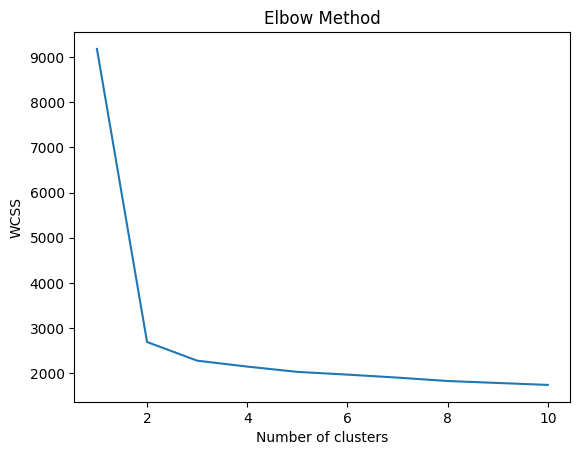

In [51]:
# NOTE: This cell has to use SciKit Learn's KMeans class due to the inertia_ attribute that measures 
#     | the sum of squared distances from each point to its assigned center.

wcss = []
max_clusters = 10
for i in range(1, max_clusters+1):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(features_standardized)
    wcss.append(kmeans.inertia_)

# Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(range(1, max_clusters+1), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') # Within cluster sum of squares
plt.show()

Three (3) appears to be the optimal K value for K-Means clustering on this dataset.

In the cell below you can modify the code to generate the report using either the SciKit Learn KMeans classifier or the custome KMeans classifier "Project_KMeans".

In [52]:
# Apply k-means with the optimal number of clusters determined
optimal_clusters = 3
# kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans = Project_KMeans(n_clusters=optimal_clusters, max_iter=300, random_state=0)
# clusters = kmeans.fit_predict(features_standardized)
kmeans.fit(features_standardized)
clusters = kmeans.predict(features_standardized)

clusters[:20]

array([1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

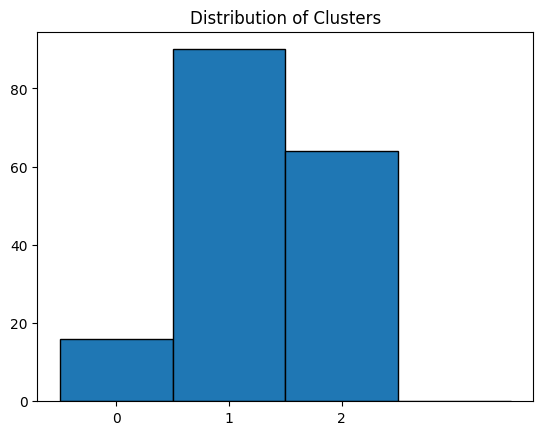

In [53]:
# Add the cluster labels to our DataFrame
data_with_clusters = features.copy()
data_with_clusters['Cluster'] = clusters

# Visualize the distribution of clusters
plt.hist(data_with_clusters['Cluster'], bins=range(optimal_clusters+2), align='left', edgecolor='black')
plt.xticks(range(optimal_clusters))
plt.title('Distribution of Clusters')
plt.show()


Now, we'll analyze each cluster by looking at the average values of the responses for each question in each cluster. With this we will get a sense of the characteristics that define our three clusters.

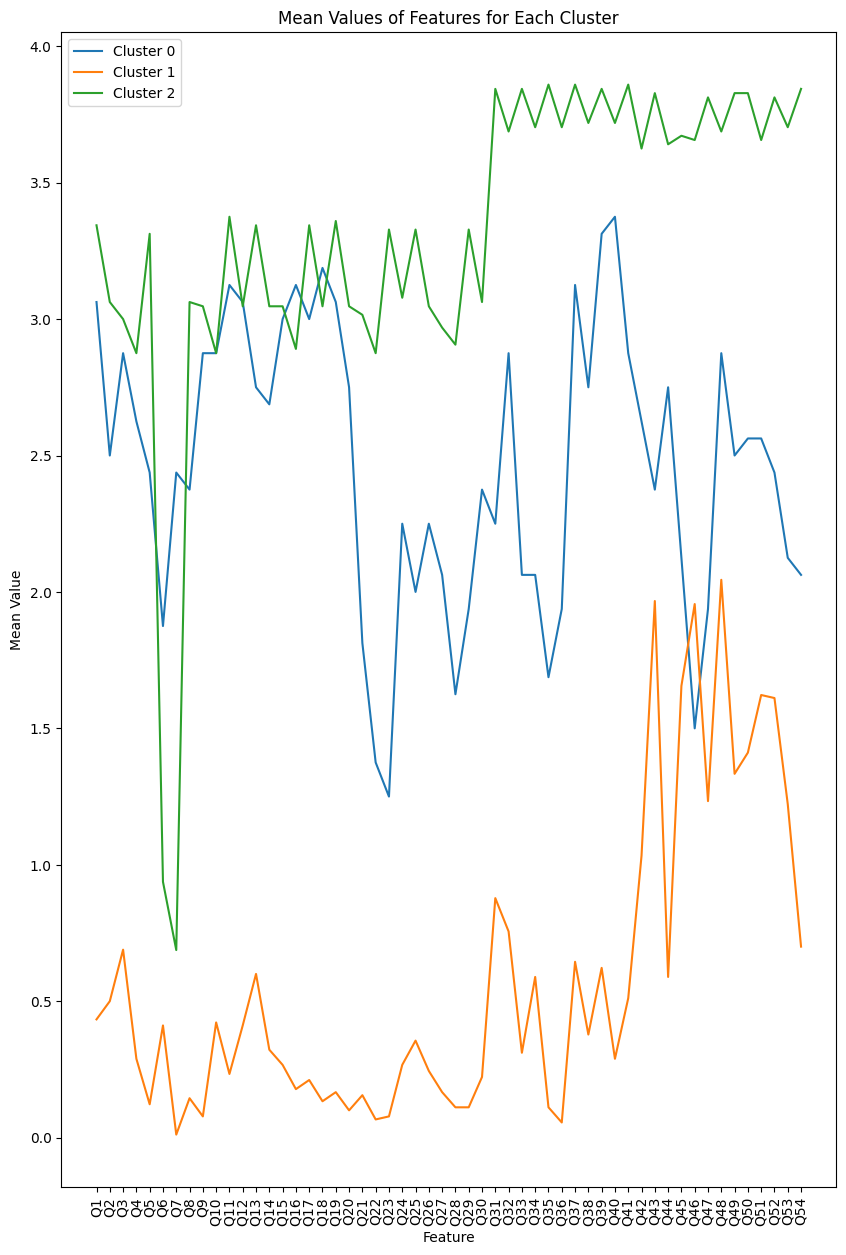

In [54]:
# Calculate the mean values for each cluster
cluster_means = data_with_clusters.groupby('Cluster').mean()

# Transpose the DataFrame for easier plotting
cluster_means = cluster_means.transpose()

# Plot the mean values for each cluster
plt.figure(figsize=(10,15))
for i in range(optimal_clusters):
    plt.plot(cluster_means[i], label=f'Cluster {i}')
plt.legend()
plt.title('Mean Values of Features for Each Cluster')
plt.xlabel('Feature')
plt.ylabel('Mean Value')
plt.xticks(rotation=90)
plt.show()


Now we can start to understand our three clusters.

- Cluster 0: This cluster has significantly higher averages than the other clusters for questions 21-54, showing that respondents in this cluster were far more likely to answer 3s or 4s on the questions, indicating that they "Frequently" or "Always" agreed with the question. Although, it should be noted that for the initial questions 1-20, this cluster had very similar averages to cluster 2.

- Cluster 1: This cluster had significantly lower averages for almost all the questions, showing that respondents in this cluster were far more likely to answer 0s or 1s on the questions, indicating that they "Never" or "Rarely" agreed with the question. Although, it should be noted that for question 46 this cluster had a higher average than cluster 2.

- Cluster 2: This cluster is the median group. They had averages that typically fell in between the other two clusters. In this cluster, respondents where likely to answer 1s, 2s, or 3s on the questions, indicating that they "Seldom", "Averagely", or "Frequently" agreed with the question. It should be noted that for questions 6, 7, 10, 12, 16, and 18 this cluster had a higher average than cluster 0, indeed for these questions this cluster had the highest average.

In conclusion, without even looking at the questions to see what was asked, we can conclude that cluster 0 was the most likely to answer extremely in the affirmative, cluster 1 was most likely to answer extremely in the negative, and cluster 2 was the median group. Let's move on to see how these cluster's are related to happy marriages and divorces.

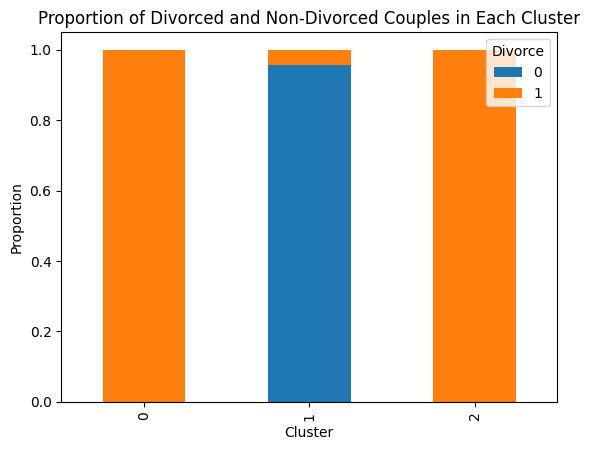

In [55]:
# Add the 'Divorce' column back into the DataFrame
data_with_clusters['Divorce'] = data['Divorce']

# Calculate the proportion of divorced and non-divorced couples in each cluster
divorce_proportions = data_with_clusters.groupby('Cluster')['Divorce'].value_counts(normalize=True)

# Convert the multi-index series to a DataFrame and reset the index
divorce_proportions = divorce_proportions.to_frame()
divorce_proportions.columns = ['Proportion']
divorce_proportions.reset_index(inplace=True)

# Create a pivot table for easier plotting
divorce_pivot = divorce_proportions.pivot(index='Cluster', columns='Divorce', values='Proportion')

# Plot the proportions of divorced and non-divorced couples in each cluster
divorce_pivot.plot(kind='bar', stacked=True)
plt.title('Proportion of Divorced and Non-Divorced Couples in Each Cluster')
plt.ylabel('Proportion')
plt.show()


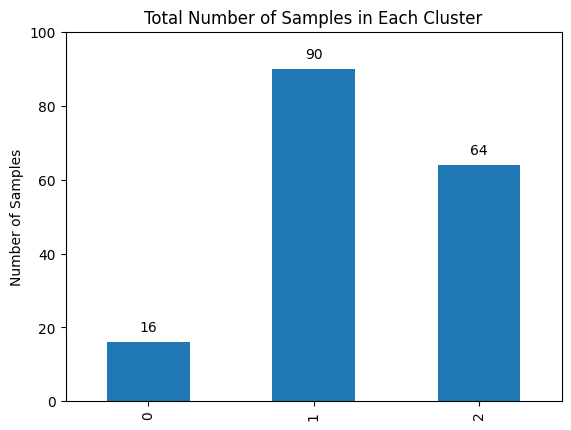

In [56]:
# Calculate the total number of samples in each cluster
cluster_counts = data_with_clusters['Cluster'].value_counts().sort_index()

# Plot the total number of samples in each cluster
ax = cluster_counts.plot(kind='bar')
plt.title('Total Number of Samples in Each Cluster')
plt.ylabel('Number of Samples')
plt.ylim(0, cluster_counts.max() + 10)  # Increase ylim

# Label the exact number of samples on the count chart
for i, v in enumerate(cluster_counts):
    ax.text(i, v + 2, str(v), ha='center', va='bottom')

plt.show()

Aha! Now we can see some very interesting things. Both cluster's 0 and 2 have a 100% divorce rate. Looking back we can see that this may mean that if you answer the questions in the affirmative most of the time, then you are likely in a relationship that will end in divorce. However, this is based on averages, so there are likely some people that answered a few questions very differently that the rest of the group. 

It's also important to take note of the value counts in each cluster, shown by the second graph above. The dataset is still balanced, even though two cluster's have a 100% divorce rate, they are smaller clusters. Taking this into account, we can likely ignore the predictive power of cluster 2 since it has only 16 samples, or 25% of cluster 0's size. Additionally, cluster 2 is our median group, so it's small and the median, meaning it's likely just a random group of samples that were outliers in the other two clusters.

This leads to a clear conclusion, if you answer the questions in the affirmative most of the time, then you are likely in a relationship that will end in divorce. However, if you answer the questions in the negative most of the time, then you are likely in a relationship that will not end in divorce. This is a very interesting result, and it's likely that this is a strong predictor of divorce.

<hr>

In [16]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [92]:
# Load the reference file for including question text in report
reference = pd.read_csv('data/reference.tsv', sep='|')
reference_dict = dict(zip(reference['atribute_id'], reference['description']))

### KNN Model with Simplified Features

First, we'll look at all the features to see which are the most correlated to divorce. To do this we'll simply calculate the pearson correlation of each question to the divorce target variable. Then we'll figure out how many features to reduce to by training the model on a variety of feature counts and seeing which one performs the best.

In [95]:
# Calculate the correlation of each feature with 'Divorce'
corrs = data.corr('pearson')['Divorce'].sort_values(ascending=False)

# Print the 5 highest for comparison
print('Questions (Features):')
corrs_questions = [reference_dict[int(f[1:])] for f in corrs[1:].index]

list_count = 1
for question, corr in zip(corrs_questions, corrs[1:]):
    print(f'\t{list_count}. {question} (Correlation: {corr:.2f})')
    list_count += 1

Questions (Features):
	1. We're just starting a discussion before I know what's going on. (Correlation: 0.94)
	2. We share the same views about being happy in our life with my spouse (Correlation: 0.93)
	3. My spouse and I have similar ideas about how roles should be in marriage (Correlation: 0.93)
	4. My spouse and I have similar ideas about how marriage should be (Correlation: 0.92)
	5. I think that one day in the future, when I look back, I see that my spouse and I have been in harmony with each other. (Correlation: 0.92)
	6. I enjoy traveling with my wife. (Correlation: 0.91)
	7. My spouse and I have similar values in trust. (Correlation: 0.91)
	8. Our dreams with my spouse are similar and harmonious. (Correlation: 0.90)
	9. Our discussions often occur suddenly. (Correlation: 0.90)
	10. When I talk to my spouse about something, my calm suddenly breaks. (Correlation: 0.89)
	11. The time I spent with my wife is special for us. (Correlation: 0.89)
	12. I know my spouse very well. (Cor

Now we will use SciKit Learn's cross validation scoring package to train and test the model using 5-fold cross validation to prevent overfitting. We'll find the optimal number of features by doing this with every single feature and doing the highest scoring one.

Our train-test split is 70-30, let's create the model.

In [68]:
knn_cv = KNeighborsClassifier(n_neighbors=5)

/Users/killianbrait/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/killianbrait/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no 

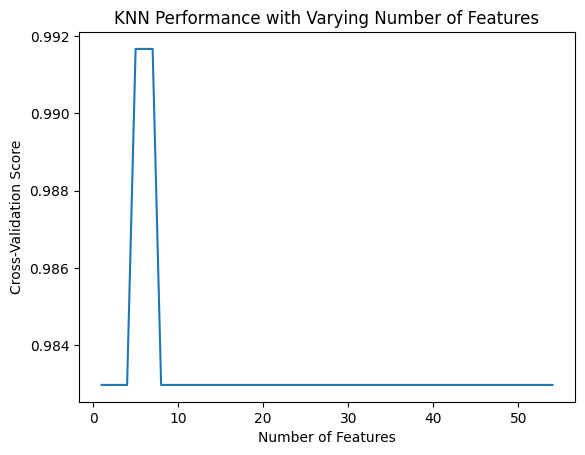

The optimal number of features is 5


In [96]:
# List to store the average cross-validation accuracy for each number of features
cv_scores = []

# This may NEED to be the SciKit Learn version of KNN
knn_cv = KNeighborsClassifier(n_neighbors=5)

# Iterate over all the questions
for i in range(1, 55):
    features_i = corrs.index[1:i+1]

    # Split the data into train and test sets
    X_train_i, X_test_i, y_train, y_test = train_test_split(features[features_i], target, test_size=0.3, random_state=0)    

    # Standardize the features
    scaler = StandardScaler()
    X_train_i_scaled = scaler.fit_transform(X_train_i)
    X_test_i_scaled = scaler.transform(X_test_i)

    # Perform 5-fold cross-validation
    scores = cross_val_score(knn_cv, X_train_i_scaled, y_train, cv=5)

    # Append the average score to cv_scores
    cv_scores.append(scores.mean())

# Find the number of features that gave the highest average cross-validation score
optimal_features = cv_scores.index(max(cv_scores)) + 1  # Add 1 because index starts at 0

# Plot the cross-validation scores
plt.plot(range(1, 55), cv_scores)
plt.xlabel('Number of Features')
plt.ylabel('Cross-Validation Score')
plt.title('KNN Performance with Varying Number of Features')
plt.show()

print(f'The optimal number of features is {optimal_features}')


# Custom KNN implementation

Now that we have decided on our top 5 features, we can create our custom KNN implementation.

Now let's move on to implement the k-NN algorithm from scratch. The steps are as follows:

1.) Calculate Euclidean distance between two instances.


2.) Get the k nearest neighbors of a given test instance.

3.) Predict the class of the test instance by taking the mode of the class labels of the k nearest neighbors.

Let's start by defining the function for calculating the Euclidean distance.

In [27]:
def calculate_euclidean_distance(instance1, instance2):
    """
    Calculate the Euclidean distance between two instances.
    - instance1: first instance
    - instance2: second instance
    """
    return np.sqrt(np.sum((instance1 - instance2) ** 2)) # subtracts corresponding elements of the two arrays

Next, we'll implement the function to get the k nearest neighbors of a given test instance. This function will compute the Euclidean distance from the test instance to each training instance, keep track of the k instances with the smallest distances, and return their indices.

In [28]:
def get_k_nearest_neighbors(X_train, x_test, k):
    """
    Get the k nearest neighbors of a test instance.
    - X_train: training features
    - x_test: test instance
    - k: number of neighbors to return
    """
    # Calculate the Euclidean distance from the test instance to each training instance
    distances = np.array([calculate_euclidean_distance(x_train, x_test) for x_train in X_train])
    
    # Get the indices of the k training instances with the smallest distances
    nearest_neighbors = distances.argsort()[:k]
    
    return nearest_neighbors

Now, we implement the function to predict the class of a test instance. This function will get the k nearest neighbors of the test instance, find the most common class label among these neighbors, and return this class label as the prediction.

In [30]:
from scipy import stats
def predict_with_k_nearest_neighbors(X_train, y_train, x_test, k):
    """
    Predict the class of a test instance using the k nearest neighbors.
    - X_train: training features
    - y_train: training target values
    - x_test: test instance
    - k: number of neighbors to consider
    """
    # Get the k nearest neighbors of the test instance
    nearest_neighbors = get_k_nearest_neighbors(X_train, x_test, k)
    
    # Get the class labels of the nearest neighbors
    class_labels = y_train[nearest_neighbors]
   
    # Predict the most common class label
    prediction = stats.mode(class_labels)[0]
    
    return prediction

# Test the function
# prediction = predict_with_k_nearest_neighbors(X_train, y_train, X_test[0], 3)
# print(f"Predicted class: {prediction}, Actual class: {target_test.values[0]}")

The next step is to use this function to make predictions for multiple test instances. 

In [31]:
def predict_with_k_nearest_neighbors_multiple(X_train, y_train, X_test, k):
    """
    Predict the class of multiple test instances using the k nearest neighbors.
    - X_train: training features
    - y_train: training target values
    - X_test: test features
    - k: number of neighbors to consider
    """
    # Make predictions for each test instance
    predictions = [predict_with_k_nearest_neighbors(X_train, y_train, x_test, k) for x_test in X_test]
    
    return predictions

# # Test the function
# predictions = predict_with_k_nearest_neighbors_multiple(X_train, y_train, X_test, 3)
# print(f"Predicted classes: {predictions[:10]}, Actual classes: {y_test[:10]}")

The custom implementation of the k-Nearest Neighbors (k-NN) algorithm is working correctly. It made correct predictions for the first 10 instances in the test set!


Now that we have implemented and tested the k-NN algorithm from scratch, let's evaluate its performance on the entire test set. We'll compute the accuracy and F1 score as we did before.

The custom implementation of the k-Nearest Neighbors (k-NN) algorithm achieved an accuracy of approximately 0.971 (or 97.1%) and an F1 score of approximately 0.974 on the test data. These values are quite high and turned out to be the same as the scikit-learn k-NN. Now, let's compute the permutation feature importance for both the scikit-learn and custom k-NN models.

# Now let's run the from scratch implementation alongside the sklearn implementation

So, let's train the model with these top 5 features and see how it performs. It's looking pretty good in the cross validation results!

In [102]:
from sklearn.metrics import accuracy_score, f1_score

# Split the data into train and test sets
top_features = corrs[1:optimal_features+1].index
X_train_top, X_test_top, y_train, y_test = train_test_split(features[top_features], target, test_size=0.3, random_state=0)

# Standardize the features
X_train_top_scaled = scaler.fit_transform(X_train_top)
X_test_top_scaled = scaler.transform(X_test_top)

# Initialize and train the KNN model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_top_scaled, y_train)


# Do the same steps for the from scratch model
# Make predictions for the entire test set
predictions = predict_with_k_nearest_neighbors_multiple(X_train_top_scaled, y_train, X_test_top_scaled, 5)

# Compute accuracy
accuracy_knn_custom = accuracy_score(y_test, predictions)

# Compute F1 score
f1_knn_custom = f1_score(y_test, predictions)

accuracy_knn_custom, f1_knn_custom

KNeighborsClassifier()

In [99]:
# Make predictions on the test set
y_pred_top = knn.predict(X_test_top_scaled)

# Calculate the confusion matrix and accuracy score
conf_mat_top = confusion_matrix(y_test, y_pred_top)
acc_score_top = accuracy_score(y_test, y_pred_top)
classification_metrics_top = classification_report(y_test, y_pred_top)

# Print the results of the model

print('Confusion Matrix:\n', conf_mat_top)
print('-'*50)
print('Accuracy Score:', acc_score_top)
print('-'*50)
print('Classification Report:\n', classification_metrics_top)
print('-'*50)

Confusion Matrix:
 [[27  0]
 [ 2 22]]
--------------------------------------------------
Accuracy Score: 0.9607843137254902
--------------------------------------------------
Classification Report:
               precision    recall  f1-score   support

           0       0.93      1.00      0.96        27
           1       1.00      0.92      0.96        24

    accuracy                           0.96        51
   macro avg       0.97      0.96      0.96        51
weighted avg       0.96      0.96      0.96        51

--------------------------------------------------


/Users/killianbrait/miniconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Looks pretty great! The model is performing very well with high accuracy and perfect recall for the non-divorced class and perfect precision for the divorced class. Additionally the confusion matrix shows that the model only got 2 false negatives. The model is slightly more precise at predicting divorced couples, and is more likely to predict that a couple will not be divorced as these are the only two predictions it got wrong, predicting no divorce and the result being divorce.

Let's take a look at some of the features that weren't used in the model alonside the features that were used to get a better idea of the model that was created.

In [101]:
# Print the 5 highest for comparison
print('Top Features Questions:')
top_features = corrs[1:optimal_features+1]
top_features_questions = [reference_dict[int(f[1:])] for f in top_features.index]

list_count = 1
for question, corr in zip(top_features_questions, top_features):
    print(f'\t{list_count}. {question} (Correlation: {corr:.2f})')
    list_count += 1


# Print the 5 lowest for comparison
lowest_features = corrs[-5:]
lowest_features_questions = [reference_dict[int(f[1:])] for f in lowest_features.index]

print('-'*50)
print('Five Lowest Correlated Questions:')
list_count = 50
for question, corr in zip(lowest_features_questions, lowest_features):
    print(f'\t{list_count}. {question} (Correlation: {corr:.2f})')
    list_count += 1


# Print the 5 middle for comparison
middle_index = len(corrs) // 2
middle_features = corrs[middle_index-2:middle_index+3]
middle_features_questions = [reference_dict[int(f[1:])] for f in middle_features.index]

print('-'*50)
print('Five Middle Correlated Questions:')
list_count = middle_index-2
for question, corr in zip(middle_features_questions, middle_features):
    print(f'\t{list_count}. {question} (Correlation: {corr:.2f})')
    list_count += 1

Top Features Questions:
	1. We're just starting a discussion before I know what's going on. (Correlation: 0.94)
	2. We share the same views about being happy in our life with my spouse (Correlation: 0.93)
	3. My spouse and I have similar ideas about how roles should be in marriage (Correlation: 0.93)
	4. My spouse and I have similar ideas about how marriage should be (Correlation: 0.92)
	5. I think that one day in the future, when I look back, I see that my spouse and I have been in harmony with each other. (Correlation: 0.92)
--------------------------------------------------
Five Lowest Correlated Questions:
	50. I mostly stay silent to calm the environment a little bit. (Correlation: 0.57)
	51. I'd rather stay silent than discuss with my spouse. (Correlation: 0.55)
	52. We are like two strangers who share the same environment at home rather than family. (Correlation: 0.54)
	53. Even if I'm right in the discussion, I stay silent to hurt my spouse. (Correlation: 0.44)
	54. We don't ha

The findings of this model are rather interesting. It is hard to pull a concrete conclusion from such a small sample size, but the testing appears to show the model is not overfitting. 

In some ways, this makes a lot of sense. The dataset is a survey of Romanian couples, and the questions are meaningful relationship questions, developed under leading relationship psychology practices. However, I think the correlation of the features is very interesting.

Below is a sentiment analysis using textblob of these different sets of questions. The sentiment analysis is a score from -1 to 1, with -1 being very negative, 0 being neutral, and 1 being very positive. The questions in this test should have neutral sentiment since this is a pyschological survey of marriages in Romania.

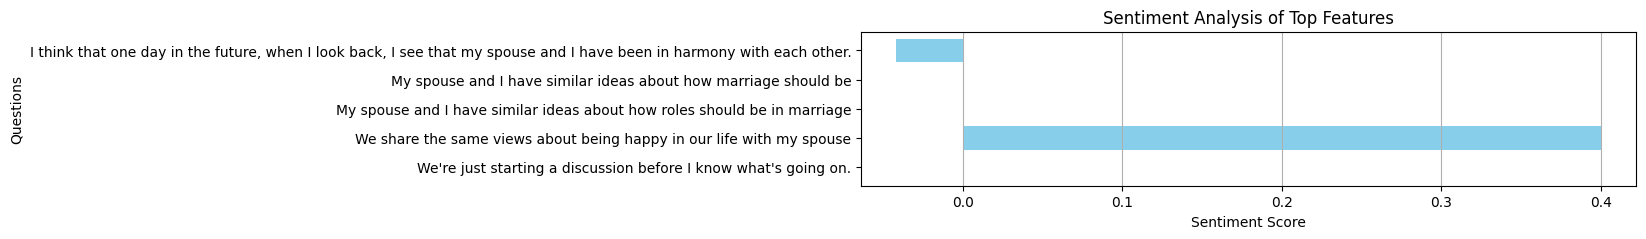

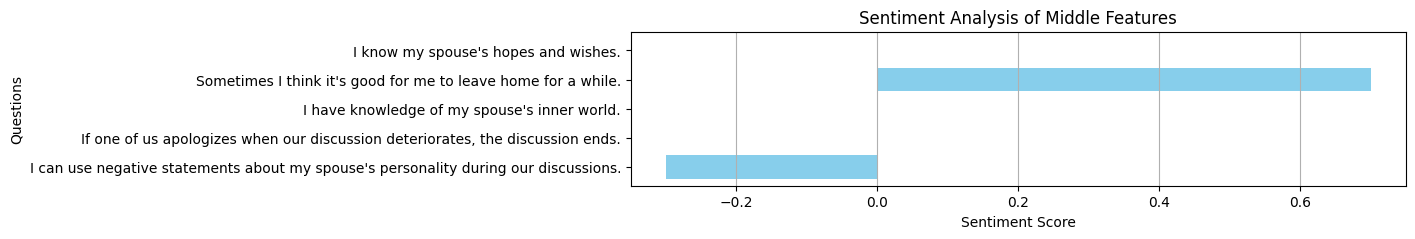

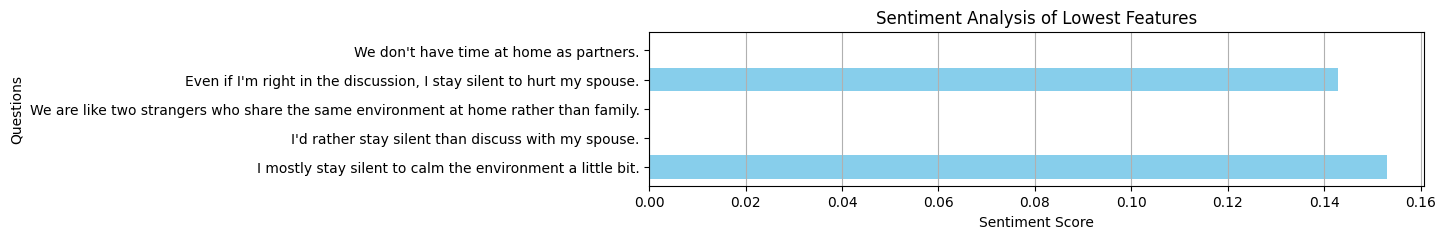

In [14]:
from textblob import TextBlob

# Define a function to calculate sentiments and plot them
def plot_sentiments(features_questions, title):
    features = []
    sentiments = []

    # Calculate the sentiment for each question
    for question in features_questions:
        blob = TextBlob(question)
        features.append(question)
        sentiments.append(blob.sentiment.polarity)

    # Create a bar plot of the sentiment scores
    plt.figure(figsize=(10, len(features_questions)//2))
    plt.barh(features, sentiments, color='skyblue')
    plt.title(title)
    plt.xlabel('Sentiment Score')
    plt.ylabel('Questions')
    plt.grid(axis='x')
    plt.show()

# Plot sentiments for top, middle, and lowest features
plot_sentiments(top_features_questions, 'Sentiment Analysis of Top Features')
plot_sentiments(middle_features_questions, 'Sentiment Analysis of Middle Features')
plot_sentiments(lowest_features_questions, 'Sentiment Analysis of Lowest Features')

As we can see, most of the questions have a sentiment score of 0.00, which means they are neutral. However, I think the sentiment analysis is placing too much weight on individual words since the sentences used in the sentiment analysis are rather short and concise. Even the ones that register some significant sentiment (>0.5) are neutral when you read them. I think this is a limitation of the sentiment analysis tool used.